In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import math
import random
%matplotlib inline

In [2]:
# defining a parabolic function for Y values
def f(x):
  return 4*(x**2) + 2*x + 1

In [3]:
# creating a list of X values
x = np.arange(-10, 10, 0.5)
y = f(x)
print('\nvalues of x: ', x)
print('\nvalues of y: ', y)


values of x:  [-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5]

values of y:  [381. 343. 307. 273. 241. 211. 183. 157. 133. 111.  91.  73.  57.  43.
  31.  21.  13.   7.   3.   1.   1.   3.   7.  13.  21.  31.  43.  57.
  73.  91. 111. 133. 157. 183. 211. 241. 273. 307. 343. 381.]


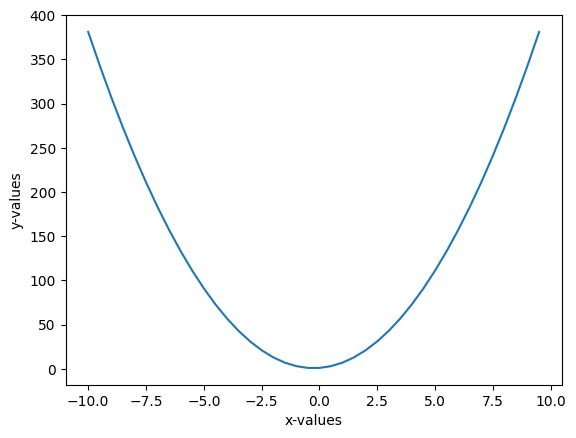

In [4]:
# plotting x and y values on a graph
plt.xlabel("x-values")
plt.ylabel("y-values")
plt.plot(x, y)

In [5]:
# derivative intuition, at a single pt x = 7.5
x = 7.5
# a small change in x which we will call h, here h is tending to 0 hence it is a very small value
h = 0.0000001
# calculating the value of y at x = 7.5, the original value
y_0 = f(x)
# calculating the value of y at x = 7.5 + h, the new value
y_1 = f(x+h)

# calculating the slope at that pt 
slope = (y_1 - y_0)/h
print('Slope at x = 7.5 is: ', slope)

Slope at x = 7.5 is:  62.00000058242949


In [6]:
# small change
h = 0.000001

# now trying this intuition for more complex functions
a = 2.3
b = -10.0
c = 5.5

# monitering slope when value of a changes a bit
da_0 = a*b + c
da_1 = (a+h)*b + c

print('da_0: ', da_0)
print('da_1: ', da_1)
print('Slope when a changes a bit: ', (da_1 - da_0)/h)

# monitering slope when value of b changes a bit
db_0 = a*b + c
db_1 = a*(b+h) + c

print('\ndb_0: ', db_0)
print('db_1: ', db_1)
print('Slope when b changes a bit: ', (db_1 - db_0)/h)

# monitering slope when value of c changes a bit
dc_0 = a*b + c
dc_1 = a*b + (c+h)

print('\ndc_0: ', dc_0)
print('dc_1: ', dc_1)
print('Slope when c changes a bit: ', (dc_1 - dc_0)/h)

da_0:  -17.5
da_1:  -17.50001
Slope when a changes a bit:  -9.999999999621423

db_0:  -17.5
db_1:  -17.4999977
Slope when b changes a bit:  2.2999999984563146

dc_0:  -17.5
dc_1:  -17.499999
Slope when c changes a bit:  1.0000000010279564


In [7]:
"""
now we will create a data structure in order to store the expressions for neural network
we need to keep track and keep pointers of what values produce what values hence the data structure is created accordingly

"""
class value:
    
    def __init__(self, data, _parents=(), _operation='', label=''):
        self.data = data
        self._prev = set(_parents)
        self._operation = _operation
        self.label = label
        self.gradient = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f'value(data = {self.data}, grad = {self.gradient})'
    
    '''<overloading operators>'''
    def __add__(self, other):
        other = other if isinstance(other, value) else value(other)
        sum = value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.gradient += sum.gradient
            other.gradient += sum.gradient
        sum._backward = _backward
        
        return sum
    
    def __radd__(self, other): # reverse addition (other + self)
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other): # reverse subtraction (other - self)
        return other + (-self)
    
    def __mul__(self, other):
        other = other if isinstance(other, value) else value(other)
        product = value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.gradient += other.data * product.gradient
            other.gradient += self.data * product.gradient
        product._backward = _backward
        
        return product
    
    def __rmul__(self, other): # reverse multiplication (other * self)
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int and float powers'
        out = value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.gradient += (other * self.data**(other-1)) * out.gradient    
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __rtruediv__(self, other): # reverse division (other / self)
        return other * self**-1
    
    def exp(self):
        x = self.data
        e = value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.gradient += e.data * e.gradient
        e._backward = _backward
        
        return e
    '''</overloading operators>'''
    
    '''<activation functions>'''
    def tanh(self):
        x = self.data
        n = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        t = value(n, (self, ), 'tanh')
        
        def _backward():
            self.gradient += (1 - n**2) * t.gradient
        t._backward = _backward
        
        return t
    
    def relu(self):
        out = value(0 if self.data < 0 else self.data, (self, ), 'relu')
        
        def _backward():
            self.gradient += (out.data > 0) * out.gradient 
        out._backward = _backward
        
        return out
    
    def sigmoid(self):
        x = self.data
        s = value(1/(1 + math.exp(-x)), (self, ), 'sigmoid')
        
        def _backward():
            self.gradient += (s.data * (1 - s.data)) * s.gradient
        s._backward = _backward
        
        return s
    '''</activation functions>'''
    
    '''<backpropagation>'''
    def backward(self):
        # topological sort in a graph
        topo = []
        visited = set()
        def build(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build(child)
                topo.append(v)
        build(self)
        
        # go one variable at a time and apply chain rule to it
        self.gradient = 1
        for node in reversed(topo):
            node._backward()
    '''</backpropagation>'''
    
    '''<visualization methods>'''
    def _trace(_root):
        # builds a set of all nodes and edges in a graph
        _nodes, _edges = set(), set()
        # recursively builds the graph by looking at all the parents of each node
        def _build(v):
            if v not in _nodes:
                _nodes.add(v)
                for parent in v._prev:
                    _edges.add((parent, v))
                    _build(parent)
        _build(_root)
        return _nodes, _edges
    
    def draw_graph(self):
        _dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
        nodes, edges = self._trace()
        
        for n in nodes:
            uid = str(id(n))
            # for any value in the graph, create a rectangular ('record') node for it
            _dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.gradient), shape='record', style='filled', fillcolor='lightblue')
            # operation nodes are pseudo nodes, just expressed as nodes as node for connecting to actual nodes
            if n._operation:
                # if this value is a result of some operation, create an operation node for it
                _dot.node(name = uid + n._operation, label = n._operation, shape='circle', style='filled', fillcolor='orange')
                # and connect this node to it
                _dot.edge(uid + n._operation, uid, style='dashed')

        for n1, n2 in edges:
            # connect n1 to the operation node of n2
            _dot.edge(str(id(n1)), str(id(n2)) + n2._operation, style='dashed')

        return _dot
    '''</visualization methods>'''

In [8]:
# testing the data structure
p = value(20.3, label='p')
q = value(10.0, label='q')
r = p * q; r.label = 'r'

print('The set values from which r was generated from: ', r._prev)
print('The opertaion from which r was genertaed: ', r._operation)
print('The value of r: ', r)

The set values from which r was generated from:  {value(data = 10.0, grad = 0), value(data = 20.3, grad = 0)}
The opertaion from which r was genertaed:  *
The value of r:  value(data = 203.0, grad = 0)


In [9]:
a = value(2.3, label='a')
b = value(-10.0, label='b')

c = a+b; c.label = 'c'
d = value(5.5, label='d')

e = c*d; e.label = 'e'
f = value(4.0, label='f')

g = e*f; g.label = 'g'

In [10]:
# manually calculating the gradient of g wrt a, b, c, d, e, f

# dg/dg = 1
g.gradient = 1.0

# g = e*f
# dg/de = f = f.data = 4.0
e.gradient = g.gradient * f.data

# g = e*f
# dg/df = e = e.data = -42.35
f.gradient = g.gradient * e.data

# dg/dc = (dg/de) * (de/dc)
# e = c*d
# de/dc = d = d.data = 5.5
# dg/dc = e.gradient * de/dc
c.gradient = e.gradient * d.data

# dg/dd = (dg/dc) * (dc/dd)
# e = c*d
# de/dd = c = c.data = -7.7
# dg/dd = e.gradient * de/dd
d.gradient = e.gradient * c.data

# dg/da = (dg/de) * (de/dc) * (dc/da) = (dg/dc) * (dc/da)
# c = a+b
# dc/da = 1
a.gradient = c.gradient

# dg/db = (dg/de) * (de/dc) * (dc/db) = (dg/dc) * (dc/db)
# c = a+b
# dc/db = 1
b.gradient = c.gradient

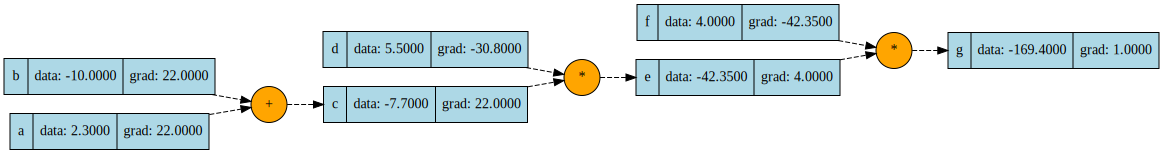

In [11]:
g.draw_graph()

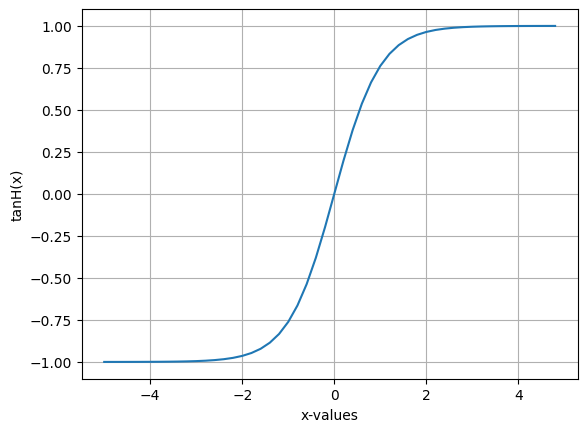

In [12]:
# tanh activation function
plt.xlabel("x-values")
plt.ylabel("tanH(x)")
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [13]:
# inputs for backpropogation for a single neuron

# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(5, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# output with tanh activation
out = n.tanh(); out.label = 'out'

In [14]:
out.backward()

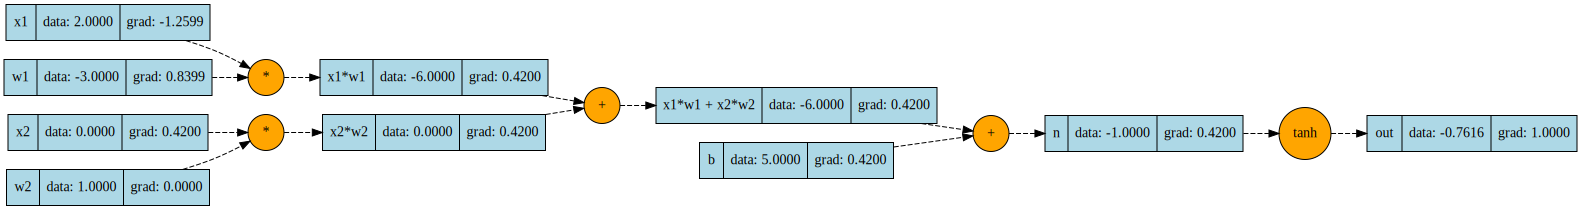

In [15]:
out.draw_graph()

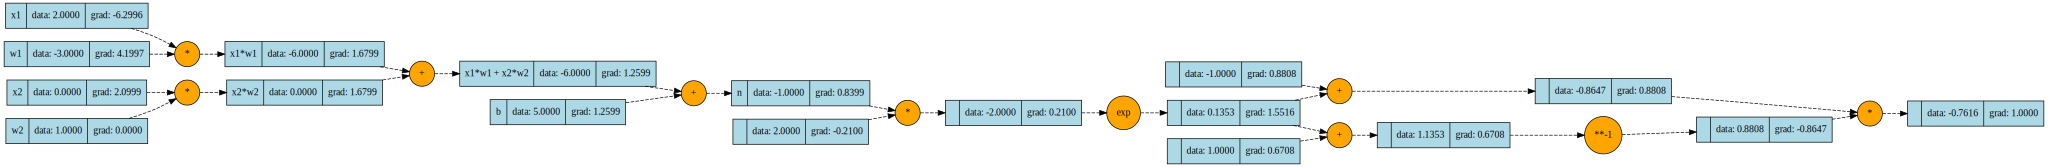

In [16]:
# output with tanh activation building up from sctrach
e = (2*n).exp()
out = (e - 1) / (e + 1)
out.backward()
out.draw_graph()

In [17]:
# building a neural network library

# class module is a base class for all the other classes
class module:
    
    def zero_grad(self):
        for p in self.parameters():
            p.gradient = 0
            
    def parameters(self):
        return []

class neuron(module):
    
    def __init__(self, num_in , _activation = ''):
        self.weights = [value(random.uniform(-1, 1), label=f'w{i}') for i in range(num_in)]
        self.bias = value(0, label='b')
        self._activation = _activation
        
    def __call__(self, x):
        raw = sum((wi*xi for wi, xi in zip(self.weights, x)), self.bias)
        act = raw.sigmoid() if self._activation == 'sigmoid' \
            else raw.tanh() if self._activation == 'tanh' \
            else raw.relu() if self._activation == 'relu' else raw.tanh()
        return act
    
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self):
        return f"\nneuron(weights: {len(self.weights)}) - activation: '{self._activation.capitalize()}'"
    
class layer(module):
        
        # num_out = number of units in the layer, num_in = number of inputs to each unit
        def __init__(self, num_in, num_out, _activation = ''):
            self.neurons = [neuron(num_in, _activation) for _ in range(num_out)]
            
        def __call__(self, x):
            out = [n(x) for n in self.neurons]
            return out[0] if len(out) == 1 else out
        
        def parameters(self):
            #return [p for n in self.neurons for p in n.parameters()]
            params = []
            for n in self.neurons:
                p_unit = n.parameters()
                params.extend(p_unit)
            return params
        
        def __repr__(self):
            return f"\nlayer of {len(self.neurons)} neurons: [{', '.join(str(n) for n in self.neurons)}]"   
        
class network(module):
    
    # num_out = list which defines size of each layer, num_in = number of inputs
    def __init__(self, num_in, layer_sizes, unit_activation = ''):
        self.unit_activation = unit_activation
        size  = [num_in] + layer_sizes
        self.layers = [layer(size[i], size[i+1], unit_activation) for i in range(len(layer_sizes))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        #return [p for layer in self.layers for p in layer.parameters()]
        params = []
        for layer in self.layers:
            p_layer = layer.parameters()
            params.extend(p_layer)
        return params
    
    def __repr__(self):
        return f"neural network of {len(self.layers)} layers: [{', '.join(str(layer) for layer in self.layers)}\n]"
    
    def summary(self):
        print(f"Network architecture:")
        print("--------------------------------------")
        print(self)
        print("--------------------------------------")
        print(f"Total number of parameters: {len(self.parameters())}")
        print(f"Total number of dense layers: {len(self.layers)}")
        print(f"Total number of neurons: {sum(len(layer.neurons) for layer in self.layers)}")
        print(f"Total number of weights: {sum(len(layer.neurons[0].weights) for layer in self.layers)}")
        print(f"Total number of biases: {sum(len(layer.neurons) for layer in self.layers)}")
        
    def loss(self, x, y):
        Xb, yb = x, y
        scores = list(map(self, Xb))
        # mse
        loss  = (sum((s-y)**2 for s,y in zip(scores, yb))/len(scores))
        # regularization
        lam = 0.00001
        reg_loss  = lam * (sum(p**2 for p in self.parameters())/len(self.parameters()))
        
        total_loss = loss + reg_loss
        
        return total_loss
        
    def fit(self, x, y, epochs):
        for epoch in range(epochs):
            # forward pass
            out = [self(xi) for xi in x]
            #loss = sum((pred - org)**2 for org, pred in zip(y, out))
            loss = self.loss(x, y)
            
            # setting the gradient to zero for each parameter
            self.zero_grad()
            # backward pass
            loss.backward()
            
            # update parameters
            alpha = 1.0 - 0.9*epoch/100
            for param in self.parameters():
                param.data -= param.gradient * alpha
                
            if epoch % 10 == 0:
                print(f'Epoch: {epoch+1}/{epochs} - Loss: {loss.data:.4f}')
                
    def predict(self, x):
        return [self(xi).data for xi in x]

In [18]:
# example dataset
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
y = [1.0, -1.0, -1.0, 1.0] # desired targets

model = network(num_in=3, layer_sizes=[5, 5, 1], unit_activation='tanh')

In [19]:
list(map(model, x))

[value(data = 0.8930321292588511, grad = 0),
 value(data = -0.09488360869454242, grad = 0),
 value(data = 0.2755717948697127, grad = 0),
 value(data = 0.7563467294862646, grad = 0)]

In [20]:
model.summary()

Network architecture:
--------------------------------------
neural network of 3 layers: [
layer of 5 neurons: [
neuron(weights: 3) - activation: 'Tanh', 
neuron(weights: 3) - activation: 'Tanh', 
neuron(weights: 3) - activation: 'Tanh', 
neuron(weights: 3) - activation: 'Tanh', 
neuron(weights: 3) - activation: 'Tanh'], 
layer of 5 neurons: [
neuron(weights: 5) - activation: 'Tanh', 
neuron(weights: 5) - activation: 'Tanh', 
neuron(weights: 5) - activation: 'Tanh', 
neuron(weights: 5) - activation: 'Tanh', 
neuron(weights: 5) - activation: 'Tanh'], 
layer of 1 neurons: [
neuron(weights: 5) - activation: 'Tanh']
]
--------------------------------------
Total number of parameters: 56
Total number of dense layers: 3
Total number of neurons: 11
Total number of weights: 13
Total number of biases: 11


In [21]:
model.fit(x, y, epochs=100)

Epoch: 1/100 - Loss: 0.6293
Epoch: 11/100 - Loss: 0.0025
Epoch: 21/100 - Loss: 0.0014
Epoch: 31/100 - Loss: 0.0010
Epoch: 41/100 - Loss: 0.0008
Epoch: 51/100 - Loss: 0.0006
Epoch: 61/100 - Loss: 0.0006
Epoch: 71/100 - Loss: 0.0005
Epoch: 81/100 - Loss: 0.0005
Epoch: 91/100 - Loss: 0.0005


In [22]:
model.predict(x)

[0.9857616620674691,
 -0.9787168287462543,
 -0.9768739359487704,
 0.9758632079174123]

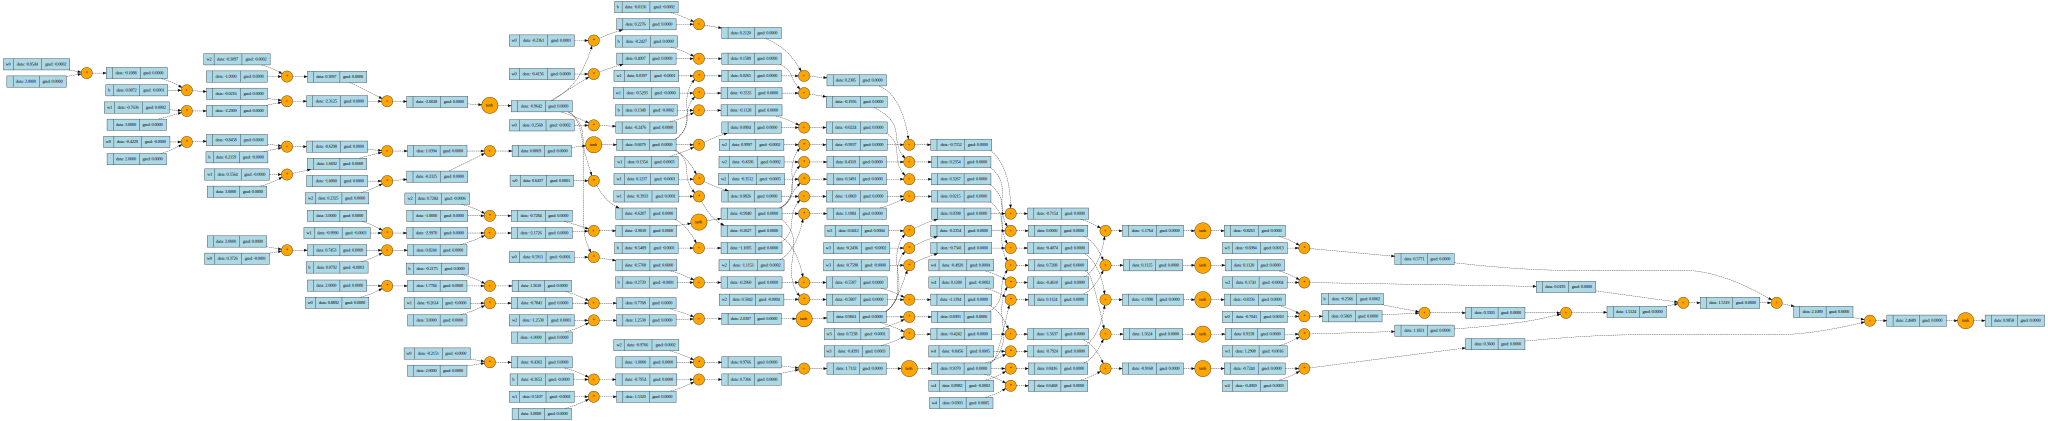

In [23]:
model(x[0]).draw_graph()